# Build Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


## Prepare data

### Read data and create a column `Year` to help increase a feature for training model.

In [2]:


data = pd.read_csv("data\cleaned_data_edited.csv",index_col="ID")
data['Year'] = pd.to_datetime(data['First registration']).dt.year.astype(int)
data.columns


C:\Users\Admin\AppData\Local\Temp\ipykernel_34716\723484289.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Year'] = pd.to_datetime(data['First registration']).dt.year.astype(int)


Index(['CARNAME', 'Make', 'Model', 'Body color', 'Interior color',
       'Interior material', 'Body', 'Doors', 'Seats', 'Fuel', 'Transmission',
       'Drive type', 'Power(kW)', 'CO2 emissions(g/km)', 'Emission class',
       'Mileage(km)', 'First registration', 'Condition',
       'Consumption(l/100km or kWh/100km)', 'Price(EUR)', 'Tags',
       'Engine capacity(ccm)', 'Previous owners', 'Year'],
      dtype='object')

### Find object columns and low cardinality columns

Due to our data have many categorical columns, we have to do one hot encoding for training model. Before handling one-hot, we have to:
- Find categorical (object) columns.
- Find columns that have low cardinality.

Why have to find columns that have low cardinality?
- For large datasets with many rows, one-hot encoding can greatly expand the size of the dataset.  For this reason, we typically will only one-hot encode columns with relatively low cardinality.  Then, high cardinality columns can either be dropped from the dataset, or we can use ordinal encoding.

In [3]:
s = (data.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables:")
print(object_cols)

low_cardinality_cols = [col for col in object_cols if data[col].nunique() < 10]
# low_cardinality_cols.append("Make")
print("Low cardinality col:")
print (low_cardinality_cols)

Categorical variables:
['CARNAME', 'Make', 'Model', 'Body color', 'Interior color', 'Interior material', 'Body', 'Doors', 'Fuel', 'Transmission', 'Drive type', 'Emission class', 'First registration', 'Condition', 'Tags']


### Find tags


- Due to the column `Tags` is a multiple value column, we have to choose which tag (special function) to do one hot encoding and put to the model 

In [5]:
one_hot_df =  data[["Price(EUR)","Tags"]].copy()

# Get each tag in each multiple value row
tags = one_hot_df['Tags'].str.split('; ', expand=True)

# Stack to make the DataFrame long, then get_dummies and group by index before summing
get_dummy = pd.get_dummies(tags.stack()).groupby(level=0).sum()
# Find the top 5 most frequent tags
top_6_tags = get_dummy.sum().nlargest(10).index
# Select only the top 5 most frequent tags
get_dummy = get_dummy[top_6_tags]
# Join the one-hot encoded DataFrame back to the original DataFrame
one_hot_df = one_hot_df.join(get_dummy)

# Drop the `Tags` because we dont need it anymore
one_hot_df = one_hot_df.drop("Tags",axis=1)
one_hot_df.columns

Index(['Price(EUR)', 'Heated front seats', 'LED headlights',
       'Navigation system', 'Apple CarPlay', 'Android auto', 'Bluetooth',
       'Keyless entry', 'Digital cockpit', 'Keyless ignition',
       'Adaptive cruise control'],
      dtype='object')

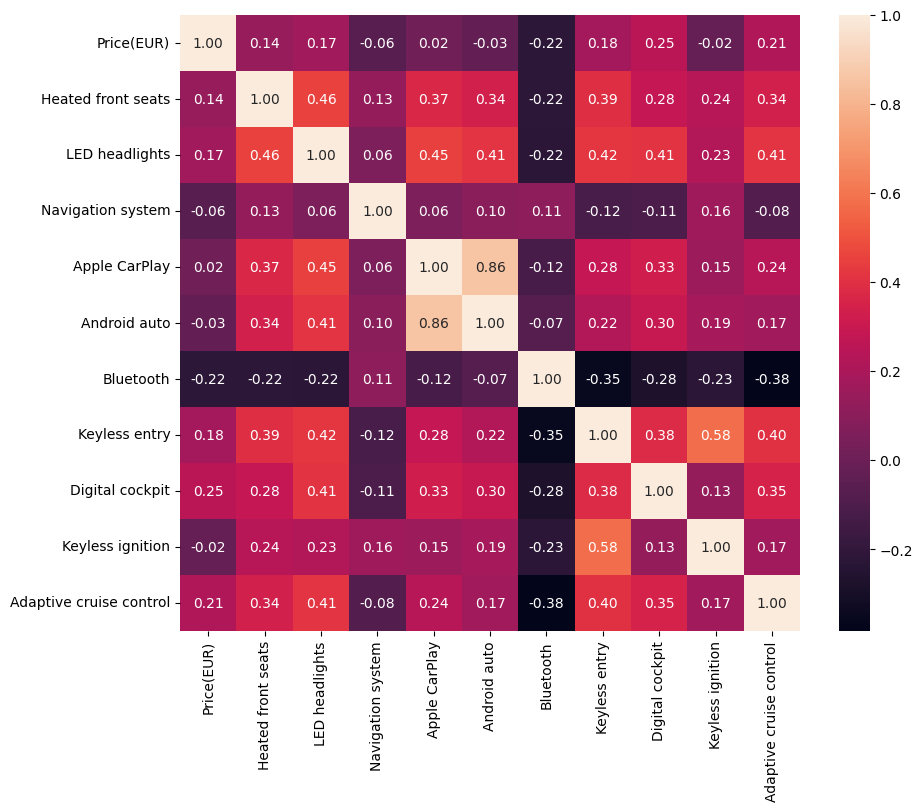

In [6]:
from scipy import stats
corre = pd.DataFrame(index=
                     one_hot_df.columns, columns=one_hot_df.columns)
for i in one_hot_df.columns:
    for j in one_hot_df.columns:
        if i != j:
            corre.loc[i, j] = stats.pointbiserialr(one_hot_df[i], one_hot_df[j])[0]
        else:
            corre.loc[i, j] = 1

# Vẽ heatmap
plt.figure(figsize=(10, 8)) # Đặt kích thước của hình
sns.heatmap(corre.astype(float), annot=True, fmt=".2f") # Vẽ heatmap
plt.show()

## Split data

- To train and test a model:
    - First we will split our data into X_train, X_valid, y_train, y_valid dataset.
    - Second, we have to handle categorical features - one hot encoding.

In [7]:
X = data.copy()
y = X["Price(EUR)"].copy()
X.drop(["Price(EUR)"], axis=1, inplace=True)
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [8]:
from sklearn.preprocessing import OneHotEncoder

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[low_cardinality_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[low_cardinality_cols]))

OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)
OH_X_train.columns = OH_X_train.columns.astype(str)
OH_X_valid.columns = OH_X_valid.columns.astype(str)

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Train model, Test and make Prediction

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

print(score_dataset(OH_X_train, OH_X_valid, y_train, y_valid))

5688.046245321272
